In [71]:
# Basic Libraries
import numpy as np
import pandas as pd
import re
import warnings
warnings.filterwarnings("ignore")

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Preprocessing
from sklearn.preprocessing import LabelEncoder, MinMaxScaler 

# Evaluation
from sklearn import metrics
from sklearn import linear_model, datasets 
from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.neighbors import LocalOutlierFactor

# Classifier (machine learning algorithm) 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier

# Read data
# https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling
dataset = pd.read_csv('../input/Churn_Modelling.csv', header = 0)

# Tmp data
dataset_tmp = dataset.copy()
dataset_tmp.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


# Functions

In [50]:
# Split Train and Test and check shape 
def SplitDataFrameToTrainAndTest(DataFrame, TrainDataRate, TargetAtt):
    # gets a random TrainDataRate % of the entire set
    training = DataFrame.sample(frac=TrainDataRate, random_state=1)
    # gets the left out portion of the dataset
    testing = DataFrame.loc[~DataFrame.index.isin(training.index)]

    X_train = training.drop(TargetAtt, 1)
    y_train = training[[TargetAtt]]
    X_test = testing.drop(TargetAtt, 1)
    y_test = testing[[TargetAtt]]

    return X_train, y_train, X_test, y_test
    
def PrintTrainTestInformation(X_train, y_train, X_test, y_test):
    print("Train rows and columns : ", X_train.shape)
    print("Test rows and columns : ", X_test.shape)

def DrawJointPlot(DataFrame, XAtt, yAtt, bins = 20):
    sns.set(color_codes=True)
    sns.distplot(data[XAtt], bins=bins);
    df = pd.DataFrame(DataFrame, columns=[XAtt,yAtt])
    df = df.reset_index(drop=True)
    sns.jointplot(x=XAtt, y=yAtt, data=df)
    
def DrawBoxplot2(DataFrame, xAtt, yAtt, hAtt="N/A"):
    plt.figure()
    if(hAtt == "N/A"):
        sns.boxplot(x=xAtt, y=yAtt,  data=DataFrame)
    else:
        sns.boxplot(x=xAtt, y=yAtt,  hue=hAtt,  data=DataFrame)
    plt.show()
    
def DrawBarplot(DataFrame, att):
    Distribution = DataFrame[att].value_counts()
    Distribution = pd.DataFrame({att:Distribution.index, 'Freq':Distribution.values})
    Distribution = Distribution.sort_values(by=att, ascending=True)
    plt.bar(Distribution[att], Distribution["Freq"])
    plt.xticks(Distribution[att])
    plt.ylabel('Frequency')
    plt.title('Barplot of ' + att)
    plt.show()   
    
def DrawCountplot(DataFrame, att, hatt="N/A"):
    if(hatt == "N/A"):
        sns.countplot(x=att, data=DataFrame)
    else:
        sns.countplot(x=att, hue=hatt, data=DataFrame)
    plt.show()
    
def DrawHistogram(DataFrame, att):
    plt.figure()
    DataFrame[att].hist(edgecolor='black', bins=20)
    plt.title(att)
    plt.show()
    
def DetectOutlierByIQR(DataFrame, AttList, Rate = 3.0): #xac dinh diem bat thuong tren tung tieu chi
    OutlierIdx = []
    for att in AttList:
        AttData = DataFrame.loc[:, att]
        lowerq = AttData.quantile(0.25)
        upperq = AttData.quantile(0.75)
        IQR = upperq - lowerq
        threshold_upper = (IQR * Rate) + upperq
        threshold_lower = lowerq - (IQR * Rate)
        AttOutlierIdx = set(AttData[AttData.apply(lambda x: x > threshold_upper
                                                    or x < threshold_lower)].index.get_values())
        OutlierIdx = set(OutlierIdx) | AttOutlierIdx

        # print("Min, Max and IQR : %f, %f, and %f" % (AttData.min(), AttData.max(), IQR))
        # print("Upper Fence and Lower Fence : %f and %f" % (threshold_lower, threshold_upper))
        # print("OutlierIdx : " + str(OutlierIdx))
        # print(att + " "  + str(len(AttOutlierIdx)) + " Outlier Idx : " + str(AttOutlierIdx))

    OutlierIdx = list(OutlierIdx)
    OutlierIdx = sorted(OutlierIdx)
    return OutlierIdx
      
def DetectOutlierByLOF(DataFrame, AttList, LOFThresh=3.0, neighbors = 10): #xac dinh diem bat thuong tren nhom tieu chi
    clf = LocalOutlierFactor(n_neighbors=neighbors)
    AttData = DataFrame.loc[:, AttList].values
    y_pred = clf.fit_predict(AttData)
    AttData_scores = -1 * clf.negative_outlier_factor_
    LOFFactorData = pd.DataFrame(AttData_scores, columns=['LOF'])
    LOFFactorData = LOFFactorData.sort_values('LOF', ascending=False)
    LOFFactorData = LOFFactorData.reset_index(drop=False)
    # print(LOFFactorData.loc[0:10, :])
    OutlierThreshold = LOFThresh
    SuspectOutlierData = LOFFactorData[LOFFactorData['LOF'].apply(lambda x: x > OutlierThreshold)]
    OutlierIdx = SuspectOutlierData.loc[:, 'index'].tolist()
    # print("OutlierIdx : " + str(OutlierIdx))
    return OutlierIdx, LOFFactorData
      
def RemoveRowsFromDataFrame(DataFrame, RowIdxList = []):
    DataFrame = DataFrame.drop(RowIdxList)
    DataFrame = DataFrame.reset_index(drop=True)
    return DataFrame

def NaiveBayesLearning(DataTrain, TargetTrain):
    NBModel = GaussianNB()
    NBModel.fit(DataTrain, TargetTrain.values.ravel())
    return NBModel

def NaiveBayesTesting(NBModel,DataTest, TargetTest):
    PredictTest = NBModel.predict(DataTest)
    Accuracy = accuracy_score(TargetTest, PredictTest)

    return Accuracy, PredictTest

def LogisticRegressionLearning(DataTrain, TargetTrain):
    logreg = LogisticRegression()
    # training by Logistic Regression
    logreg.fit(DataTrain, TargetTrain.values.ravel())

    return logreg

def LogisticRegressionTesting(LRModel,DataTest, TargetTest):
    logreg = LRModel
    PredictTest = logreg.predict(DataTest)
    Accuracy = accuracy_score(TargetTest, PredictTest)
    # print('Logistic regression accuracy: {:.3f}'.format(Accuracy))

    return Accuracy, PredictTest

def RandomForestLearning(DataTrain, TargetTrain):
    rf = RandomForestClassifier()
    rf.fit(DataTrain, TargetTrain.values.ravel())

    return rf

def RandomForestTesting(RFModel,DataTest, TargetTest):
    PredictTest = RFModel.predict(DataTest)
    Accuracy = accuracy_score(TargetTest, PredictTest)
    # print('Random Forest Accuracy: {:.3f}'.format(accuracy_score(TargetTest, PredictTest)))

    return Accuracy, PredictTest

def SVMLearning(DataTrain, TargetTrain, ClassifierType = " "):
    if(ClassifierType == 'Linear'):
        svc = SVC(kernel="linear", C=0.025)
        # print('SVM Linear processing')
    # Radial basis function kernel
    elif (ClassifierType == 'RBF'):
        svc = SVC(gamma=2, C=1)
        # print('SVM RBF processing')
    else:
        svc = SVC()
        # print('SVM Default processing')
    svc.fit(DataTrain, TargetTrain.values.ravel())
    return svc

def SVMTesting(SVMModel, DataTest, TargetTest):
    PredictTest = SVMModel.predict(DataTest)
    Accuracy = accuracy_score(TargetTest, PredictTest)
    # print('Support Vector Machine Accuracy: {:.3f}'.format(accuracy_score(TargetTest, PredictTest)))
    return Accuracy, PredictTest

def KNNLearning(DataTrain, TargetTrain, K = 3):
    neigh = KNeighborsClassifier(n_neighbors=K)
    neigh.fit(DataTrain, TargetTrain.values.ravel())

    return neigh

def KNNTesting(KNNModel,DataTest, TargetTest):
    PredictTest = KNNModel.predict(DataTest)
    Accuracy = accuracy_score(TargetTest, PredictTest)
    # print('KNN Accuracy: {:.3f}'.format(accuracy_score(TargetTest, PredictTest)))

    return Accuracy, PredictTest

def ANNLearning(DataTrain, TargetTrain):
    ANNModel = MLPClassifier(alpha=1)
    ANNModel.fit(DataTrain, TargetTrain.values.ravel())
    return ANNModel

def ANNTesting (ANNModel, DataTest, TargetTest):
    PredictTest = ANNModel.predict(DataTest)
    Accuracy = accuracy_score(TargetTest, PredictTest)
    # print('Neural Net Accuracy: {:.3f}'.format(Accuracy))
    return Accuracy, PredictTest

# Continuous Data Plot
def cont_plot(df, feature_name, target_name, palettemap, hue_order, feature_scale): 
    df['Counts'] = "" # A trick to skip using an axis (either x or y) on splitting violinplot
    fig, [axis0,axis1] = plt.subplots(1,2,figsize=(10,5))
    sns.distplot(df[feature_name], ax=axis0);
    sns.violinplot(x=feature_name, y="Counts", hue=target_name, hue_order=hue_order, data=df,
                   palette=palettemap, split=True, orient='h', ax=axis1)
    axis1.set_xticks(feature_scale)
    plt.show()
    # WARNING: This will leave Counts column in dataset if you continues to use this dataset

# Categorical/Ordinal Data Plot
def cat_plot(df, feature_name, target_name, palettemap): 
    fig, [axis0,axis1] = plt.subplots(1,2,figsize=(10,5))
    df[feature_name].value_counts().plot.pie(autopct='%1.1f%%',ax=axis0)
    sns.countplot(x=feature_name, hue=target_name, data=df,
                  palette=palettemap,ax=axis1)
    plt.show()


# Checking missing values

- Fill missing value: Median / Mode, Label Encode / Dummies

In [6]:
# Checking the percentage of missing values in each variable
(dataset.isnull().sum()/len(dataset)*100)

RowNumber          0.0
CustomerId         0.0
Surname            0.0
CreditScore        0.0
Geography          0.0
Gender             0.0
Age                0.0
Tenure             0.0
Balance            0.0
NumOfProducts      0.0
HasCrCard          0.0
IsActiveMember     0.0
EstimatedSalary    0.0
Exited             0.0
dtype: float64

## **Preparation and EDA**

In [18]:
# Split Train and Test and check shape 
data_train, target_train, data_test, target_test = SplitDataFrameToTrainAndTest(dataset, 0.6, 'Exited')
PrintTrainTestInformation(data_train, target_train, data_test, target_test)

Train rows and columns :  (6000, 13)
Test rows and columns :  (4000, 13)


In [19]:
# Check column types
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6000 entries, 9953 to 2374
Data columns (total 13 columns):
RowNumber          6000 non-null int64
CustomerId         6000 non-null int64
Surname            6000 non-null object
CreditScore        6000 non-null int64
Geography          6000 non-null object
Gender             6000 non-null object
Age                6000 non-null int64
Tenure             6000 non-null int64
Balance            6000 non-null float64
NumOfProducts      6000 non-null int64
HasCrCard          6000 non-null int64
IsActiveMember     6000 non-null int64
EstimatedSalary    6000 non-null float64
dtypes: float64(2), int64(8), object(3)
memory usage: 656.2+ KB


In [21]:
print(" List of unique values in Surname : ")
print(dataset['Surname'].unique())
print(" List of unique values in Geography : ")
print(dataset['Geography'].unique())
print(" List of unique values in Gender : ")
print(dataset['Gender'].unique())

#Special Field
print(" List of unique values in NumOfProducts : ")
print(dataset['NumOfProducts'].unique())

 List of unique values in Surname : 
['Hargrave' 'Hill' 'Onio' ... 'Kashiwagi' 'Aldridge' 'Burbidge']
 List of unique values in Geography : 
['France' 'Spain' 'Germany']
 List of unique values in Gender : 
['Female' 'Male']
 List of unique values in NumOfProducts : 
[1 3 2 4]


In [22]:
# Numerical data distribution 
data_train.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
count,6000.000000,6.000000e+03,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000
mean,5000.534667,1.569090e+07,652.017833,38.801333,5.021667,76069.556590,1.524667,0.702333,0.521833,99470.172248
std,2877.924946,7.201902e+04,96.171969,10.409335,2.888469,62709.267925,0.576582,0.457270,0.499565,57622.657250
min,4.000000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000
25%,2501.250000,1.562812e+07,586.000000,32.000000,3.000000,0.000000,1.000000,0.000000,0.000000,50343.395000
50%,4995.500000,1.569189e+07,655.000000,37.000000,5.000000,96598.420000,1.000000,1.000000,1.000000,99482.980000
75%,7483.500000,1.575351e+07,718.000000,44.000000,8.000000,127671.927500,2.000000,1.000000,1.000000,149170.417500
max,9999.000000,1.581569e+07,850.000000,92.000000,10.000000,238387.560000,4.000000,1.000000,1.000000,199992.480000


In [23]:
data_train.describe(include=['O'])

,Surname,Geography,Gender
count,6000,6000,6000
unique,2246,3,2
top,Smith,France,Male
freq,23,3026,3259


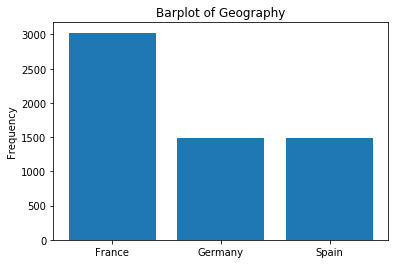

In [25]:
DrawBarplot(data_train, 'Geography')

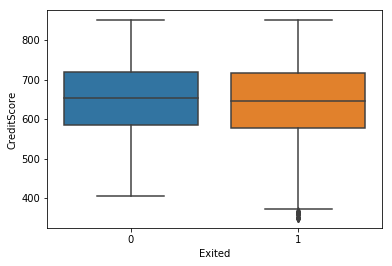

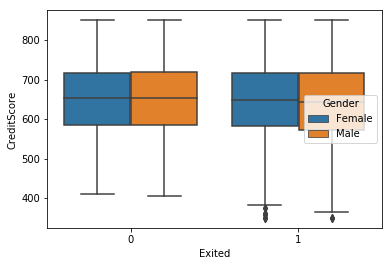

In [31]:
DrawBoxplot2(dataset, xAtt = 'Exited', yAtt='CreditScore')
DrawBoxplot2(dataset, xAtt = 'Exited', yAtt='CreditScore', hAtt='Gender')

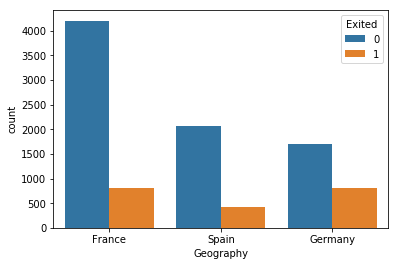

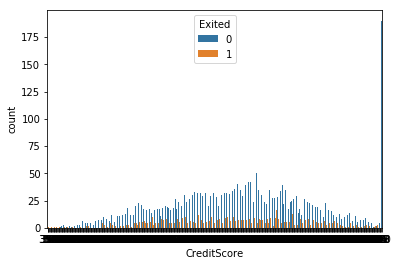

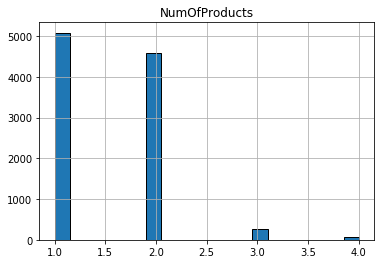

In [30]:
DrawCountplot(dataset, 'Geography', 'Exited')
DrawCountplot(dataset, 'CreditScore', 'Exited')
DrawHistogram(dataset, 'NumOfProducts')

# **Label Encoder **

In [33]:
data_encoder = dataset.copy()
data_encoder['Geography'] = LabelEncoder().fit_transform(data_encoder['Geography'])
data_encoder['Surname'] = LabelEncoder().fit_transform(data_encoder['Surname'])
data_encoder['Gender'] = LabelEncoder().fit_transform(data_encoder['Gender'])
data_encoder = data_encoder.join(pd.get_dummies(data_encoder['NumOfProducts'], prefix='NumOfProducts_'))
data_encoder = data_encoder.drop('NumOfProducts', axis=1)
data_encoder.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,HasCrCard,IsActiveMember,EstimatedSalary,Exited,NumOfProducts__1,NumOfProducts__2,NumOfProducts__3,NumOfProducts__4
0,1,15634602,1115,619,0,0,42,2,0.00,1,1,101348.88,1,1,0,0,0
1,2,15647311,1177,608,2,0,41,1,83807.86,0,1,112542.58,0,1,0,0,0
2,3,15619304,2040,502,0,0,42,8,159660.80,1,0,113931.57,1,0,0,1,0
3,4,15701354,289,699,0,0,39,1,0.00,0,0,93826.63,0,0,1,0,0
4,5,15737888,1822,850,2,0,43,2,125510.82,1,1,79084.10,0,1,0,0,0
5,6,15574012,537,645,2,1,44,8,113755.78,1,0,149756.71,1,0,1,0,0
6,7,15592531,177,822,0,1,50,7,0.00,1,1,10062.80,0,0,1,0,0
7,8,15656148,2000,376,1,0,29,4,115046.74,1,0,119346.88,1,0,0,0,1
8,9,15792365,1146,501,0,1,44,4,142051.07,0,1,74940.50,0,0,1,0,0
9,10,15592389,1081,684,0,1,27,2,134603.88,1,1,71725.73,0,1,0,0,0


In [35]:
# Split Train and Test and check shape 
data_train_encoder, target_train_encoder, data_test_encoder, target_test_encoder = SplitDataFrameToTrainAndTest(data_encoder, 0.6, 'Exited')
PrintTrainTestInformation(data_train_encoder, target_train_encoder, data_test_encoder, target_test_encoder)

Train rows and columns :  (6000, 16)
Test rows and columns :  (4000, 16)


## **Classification by trainditional models** 

In [36]:
X_train = data_train_encoder
y_train = target_train_encoder
X_test = data_test_encoder
y_test = target_test_encoder

NBModel = NaiveBayesLearning(X_train, y_train)
NBAccuracy,NBPredictTest = NaiveBayesTesting(NBModel,X_test, y_test)
print('Naive Bayes accuracy: {:.3f}'.format(NBAccuracy))

print(NBModel.predict_proba(X_test)[1,:])
print(NBPredictTest[1])
print(NBModel.predict_proba(X_test)[0,:])
print(NBPredictTest[0])

Naive Bayes accuracy: 0.775
[0.76701672 0.23298328]
0
[0.84235405 0.15764595]
0


In [37]:
LRModel = LogisticRegressionLearning(X_train, y_train)
LRAccuracy,LRPredictTest = LogisticRegressionTesting(LRModel,X_test, y_test)
print('Logistic Regression accuracy: {:.3f}'.format(LRAccuracy))

print(LRModel.predict_proba(X_test)[1,:])
print(LRPredictTest[1])
print(LRModel.predict_proba(X_test)[0,:])
print(LRPredictTest[0])

Logistic Regression accuracy: 0.798
[0.79081666 0.20918334]
0
[0.8461998 0.1538002]
0


In [38]:
RFModel = RandomForestLearning(X_train, y_train)
RFAccuracy,RFPredictTest = RandomForestTesting(RFModel,X_test, y_test)
print('Random Forest accuracy: {:.6f}'.format(RFAccuracy))

print(RFModel.predict_proba(X_test)[1,:])
print(RFPredictTest[1])
print(RFModel.predict_proba(X_test)[0,:])
print(RFPredictTest[0])

Random Forest accuracy: 0.849750
[0.7 0.3]
0
[0.6 0.4]
0


In [39]:
LiSVMModel = SVMLearning(X_train, y_train)
LiSVMAccuracy,LiSVMPredictTest = SVMTesting(LiSVMModel, X_test, y_test)
print('Linear SVM accuracy: {:.6f}'.format(LiSVMAccuracy))

RBFSVMModel = SVMLearning(X_train, y_train, 'RBF')
RBFSVMAccuracy,RBFSVMPredictTest = SVMTesting(RBFSVMModel, X_test, y_test)
print('RBF SVM accuracy: {:.6f}'.format(RBFSVMAccuracy))

Linear SVM accuracy: 0.798250
RBF SVM accuracy: 0.798250


In [40]:
KNNModel = KNNLearning(X_train, y_train)
KNNAccuracy,KNNPredictTest = KNNTesting(KNNModel,X_test, y_test)
print('K Nearest Neighbor accuracy: {:.6f}'.format(KNNAccuracy))

print(KNNModel.predict_proba(X_test)[1,:])
print(KNNPredictTest[1])
print(KNNModel.predict_proba(X_test)[0,:])
print(KNNPredictTest[0])

K Nearest Neighbor accuracy: 0.738500
[1. 0.]
0
[1. 0.]
0


In [41]:
ANNModel = ANNLearning(X_train, y_train)
ANNAccuracy, ANNPredictTest = ANNTesting(ANNModel, X_test, y_test)
print('ANN accuracy: {:.6f}'.format(ANNAccuracy))

print(ANNModel.predict_proba(X_test)[1,:])
print(ANNPredictTest[1])
print(ANNModel.predict_proba(X_test)[0,:])
print(ANNPredictTest[0])

ANN accuracy: 0.201750
[0. 1.]
1
[0. 1.]
1


# **Approach 1 ** (Feature Selection)

# Correlation

In [47]:
## get the most important variables. 
corr = dataset.corr()**2
corr.Exited.sort_values(ascending=False)

Exited             1.000000
Age                0.081409
IsActiveMember     0.024376
Balance            0.014050
NumOfProducts      0.002287
CreditScore        0.000734
RowNumber          0.000275
Tenure             0.000196
EstimatedSalary    0.000146
HasCrCard          0.000051
CustomerId         0.000039
Name: Exited, dtype: float64

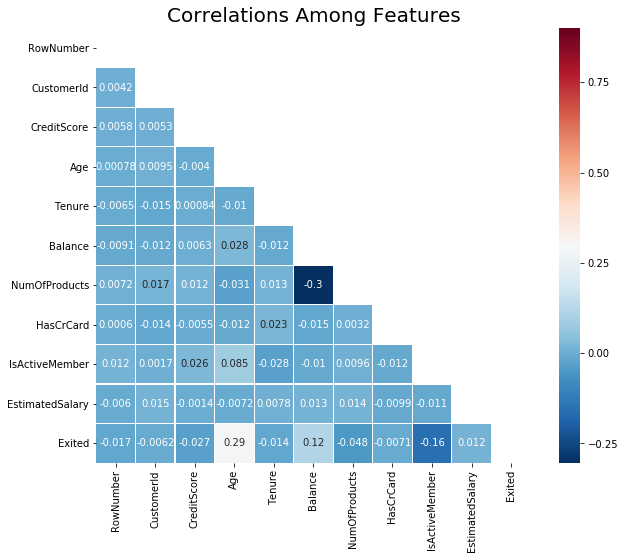

In [60]:
## heatmeap to see the correlation between features. 
# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(dataset.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# plot
plt.subplots(figsize = (10,8))
sns.heatmap(dataset.corr(), annot=True, mask = mask, cmap = 'RdBu_r', linewidths=0.1, linecolor='white', vmax = .9, square=True)
plt.title("Correlations Among Features", y = 1.03,fontsize = 20);

   NumOfProducts    Exited
3              4  1.000000
2              3  0.827068
0              1  0.277144
1              2  0.075817


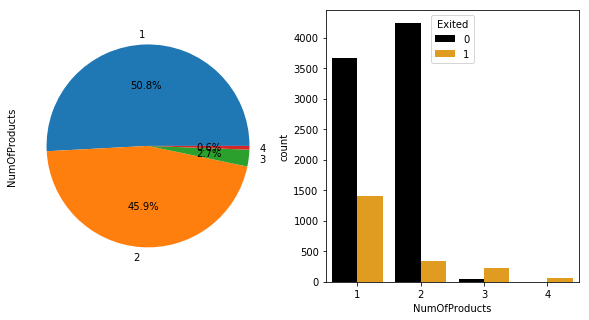

In [55]:
print(dataset[['NumOfProducts', 'Exited']].groupby(['NumOfProducts'], as_index=False).mean().sort_values(by='Exited', ascending=False))
cat_plot(dataset, 'NumOfProducts','Exited', {0: "black", 1: "orange"} )

   IsActiveMember    Exited
0               0  0.268509
1               1  0.142691


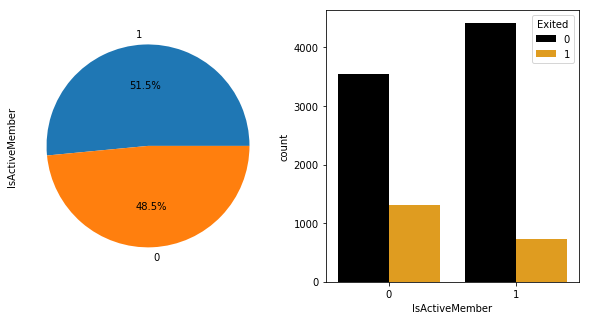

In [61]:
print(dataset[['IsActiveMember', 'Exited']].groupby(['IsActiveMember'], as_index=False).mean().sort_values(by='Exited', ascending=False))
cat_plot(dataset, 'IsActiveMember','Exited', {0: "black", 1: "orange"} )

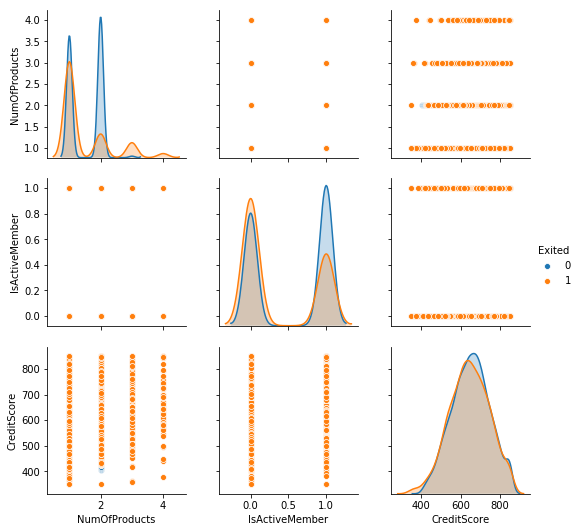

In [62]:
# https://seaborn.pydata.org/generated/seaborn.pairplot.html
sns.pairplot(dataset, vars=["NumOfProducts", "IsActiveMember", "CreditScore"], hue="Exited")

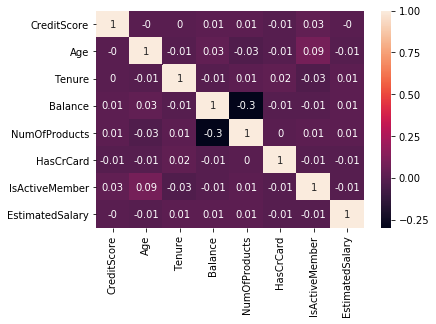

In [64]:
AttList = ["CreditScore",	"Age",	"Tenure",	"Balance",	"NumOfProducts",	"HasCrCard",	"IsActiveMember",	"EstimatedSalary"]
correlation_matrix = dataset[AttList].corr().round(2)
# annot = True to print the values inside the square
sns.heatmap(data=correlation_matrix, annot=True)

In [65]:
data_encoder_feselection = data_encoder.copy()
AttList = ["Surname", "RowNumber", "CustomerId"]
data_encoder_feselection = data_encoder_feselection.drop(AttList,  axis=1)
print(data_encoder_feselection.shape)
data_encoder_feselection.head()

(10000, 14)


,CreditScore,Geography,Gender,Age,Tenure,Balance,HasCrCard,IsActiveMember,EstimatedSalary,Exited,NumOfProducts__1,NumOfProducts__2,NumOfProducts__3,NumOfProducts__4
0,619,0,0,42,2,0.00,1,1,101348.88,1,1,0,0,0
1,608,2,0,41,1,83807.86,0,1,112542.58,0,1,0,0,0
2,502,0,0,42,8,159660.80,1,0,113931.57,1,0,0,1,0
3,699,0,0,39,1,0.00,0,0,93826.63,0,0,1,0,0
4,850,2,0,43,2,125510.82,1,1,79084.10,0,1,0,0,0


In [67]:
# Split Train and Test and check shape 
data_train_encoder_feselection, target_train_encoder_feselection, data_test_encoder_feselection, target_test_encoder_feselection = SplitDataFrameToTrainAndTest(data_encoder_feselection, 0.6, 'Exited')
PrintTrainTestInformation(data_train_encoder_feselection, target_train_encoder_feselection, data_test_encoder_feselection, target_test_encoder_feselection)

Train rows and columns :  (6000, 13)
Test rows and columns :  (4000, 13)


In [68]:
# Retest all traditional classification approaches
X_train = data_train_encoder
y_train = target_train_encoder
X_test = data_test_encoder
y_test = target_test_encoder

NBModel = NaiveBayesLearning(X_train, y_train)
NBAccuracy,NBPredictTest = NaiveBayesTesting(NBModel,X_test, y_test)
print('Naive Bayes accuracy: {:.3f}'.format(NBAccuracy))

LRModel = LogisticRegressionLearning(X_train, y_train)
LRAccuracy,LRPredictTest = LogisticRegressionTesting(LRModel,X_test, y_test)
print('Logistic Regression accuracy: {:.3f}'.format(LRAccuracy))

RFModel = RandomForestLearning(X_train, y_train)
RFAccuracy,RFPredictTest = RandomForestTesting(RFModel,X_test, y_test)
print('Random Forest accuracy: {:.6f}'.format(RFAccuracy))

LiSVMModel = SVMLearning(X_train, y_train)
LiSVMAccuracy,LiSVMPredictTest = SVMTesting(LiSVMModel, X_test, y_test)
print('Linear SVM accuracy: {:.6f}'.format(LiSVMAccuracy))

RBFSVMModel = SVMLearning(X_train, y_train, 'RBF')
RBFSVMAccuracy,RBFSVMPredictTest = SVMTesting(RBFSVMModel, X_test, y_test)
print('RBF SVM accuracy: {:.6f}'.format(RBFSVMAccuracy))

KNNModel = KNNLearning(X_train, y_train)
KNNAccuracy,KNNPredictTest = KNNTesting(KNNModel,X_test, y_test)
print('K Nearest Neighbor accuracy: {:.6f}'.format(KNNAccuracy))

ANNModel = ANNLearning(X_train, y_train)
ANNAccuracy, ANNPredictTest = ANNTesting(ANNModel, X_test, y_test)
print('ANN accuracy: {:.6f}'.format(ANNAccuracy))

Naive Bayes accuracy: 0.775
Logistic Regression accuracy: 0.798
Random Forest accuracy: 0.842000
Linear SVM accuracy: 0.798250
RBF SVM accuracy: 0.798250
K Nearest Neighbor accuracy: 0.738500
ANN accuracy: 0.798250


In [69]:
# Retest all traditional classification approaches
X_train = data_train_encoder_feselection
y_train = target_train_encoder_feselection
X_test = data_test_encoder_feselection
y_test = target_test_encoder_feselection

NBModel = NaiveBayesLearning(X_train, y_train)
NBAccuracy,NBPredictTest = NaiveBayesTesting(NBModel,X_test, y_test)
print('Naive Bayes accuracy: {:.3f}'.format(NBAccuracy))

LRModel = LogisticRegressionLearning(X_train, y_train)
LRAccuracy,LRPredictTest = LogisticRegressionTesting(LRModel,X_test, y_test)
print('Logistic Regression accuracy: {:.3f}'.format(LRAccuracy))

RFModel = RandomForestLearning(X_train, y_train)
RFAccuracy,RFPredictTest = RandomForestTesting(RFModel,X_test, y_test)
print('Random Forest accuracy: {:.6f}'.format(RFAccuracy))

LiSVMModel = SVMLearning(X_train, y_train)
LiSVMAccuracy,LiSVMPredictTest = SVMTesting(LiSVMModel, X_test, y_test)
print('Linear SVM accuracy: {:.6f}'.format(LiSVMAccuracy))

RBFSVMModel = SVMLearning(X_train, y_train, 'RBF')
RBFSVMAccuracy,RBFSVMPredictTest = SVMTesting(RBFSVMModel, X_test, y_test)
print('RBF SVM accuracy: {:.6f}'.format(RBFSVMAccuracy))

KNNModel = KNNLearning(X_train, y_train)
KNNAccuracy,KNNPredictTest = KNNTesting(KNNModel,X_test, y_test)
print('K Nearest Neighbor accuracy: {:.6f}'.format(KNNAccuracy))

ANNModel = ANNLearning(X_train, y_train)
ANNAccuracy, ANNPredictTest = ANNTesting(ANNModel, X_test, y_test)
print('ANN accuracy: {:.6f}'.format(ANNAccuracy))

Naive Bayes accuracy: 0.774
Logistic Regression accuracy: 0.795
Random Forest accuracy: 0.850750
Linear SVM accuracy: 0.798250
RBF SVM accuracy: 0.798250
K Nearest Neighbor accuracy: 0.739250
ANN accuracy: 0.597750


## Feature Importances

(6000, 16)


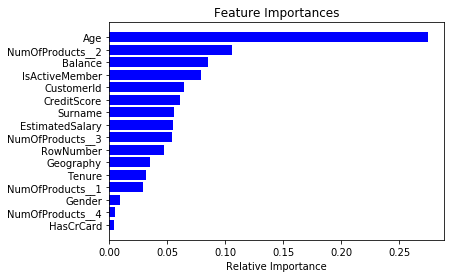

In [72]:
model = RandomForestRegressor(random_state=1, max_depth=10)
model.fit(data_train_encoder,target_train_encoder)

print(data_train_encoder.shape)
features = data_train_encoder.columns
importances = model.feature_importances_
indices = np.argsort(importances)[-len(features):]  # top features
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [73]:
# Get numerical feature importances
feature_list = list(data_train_encoder.columns)
importances = list(model.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: Age                  Importance: 0.27
Variable: NumOfProducts__2     Importance: 0.11
Variable: Balance              Importance: 0.09
Variable: IsActiveMember       Importance: 0.08
Variable: CustomerId           Importance: 0.06
Variable: Surname              Importance: 0.06
Variable: CreditScore          Importance: 0.06
Variable: EstimatedSalary      Importance: 0.06
Variable: RowNumber            Importance: 0.05
Variable: NumOfProducts__3     Importance: 0.05
Variable: Geography            Importance: 0.04
Variable: Tenure               Importance: 0.03
Variable: NumOfProducts__1     Importance: 0.03
Variable: Gender               Importance: 0.01
Variable: NumOfProducts__4     Importance: 0.01
Variable: HasCrCard            Importance: 0.0


In [75]:
# Split Train and Test and check shape 
AttSelection = ["Age", "NumOfProducts__2", "Balance", "IsActiveMember", "CustomerId",
                "Surname", "CreditScore", "EstimatedSalary", "EstimatedSalary", "RowNumber",
                "NumOfProducts__3", "Geography", "Tenure", "NumOfProducts__1",
               "Exited"]

data_train_encoder_feselection02, target_train_encoder_feselection02, data_test_encoder_feselection02, target_test_encoder_feselection02 = SplitDataFrameToTrainAndTest(data_encoder[AttSelection], 0.6, 'Exited')
PrintTrainTestInformation(data_train_encoder_feselection02, target_train_encoder_feselection02, data_test_encoder_feselection02, target_test_encoder_feselection02)

Train rows and columns :  (6000, 14)
Test rows and columns :  (4000, 14)


In [76]:
# Retest all traditional classification approaches
X_train = data_train_encoder_feselection02
y_train = target_train_encoder_feselection02
X_test = data_test_encoder_feselection02
y_test = target_test_encoder_feselection02

NBModel = NaiveBayesLearning(X_train, y_train)
NBAccuracy,NBPredictTest = NaiveBayesTesting(NBModel,X_test, y_test)
print('Naive Bayes accuracy: {:.3f}'.format(NBAccuracy))

LRModel = LogisticRegressionLearning(X_train, y_train)
LRAccuracy,LRPredictTest = LogisticRegressionTesting(LRModel,X_test, y_test)
print('Logistic Regression accuracy: {:.3f}'.format(LRAccuracy))

RFModel = RandomForestLearning(X_train, y_train)
RFAccuracy,RFPredictTest = RandomForestTesting(RFModel,X_test, y_test)
print('Random Forest accuracy: {:.6f}'.format(RFAccuracy))

LiSVMModel = SVMLearning(X_train, y_train)
LiSVMAccuracy,LiSVMPredictTest = SVMTesting(LiSVMModel, X_test, y_test)
print('Linear SVM accuracy: {:.6f}'.format(LiSVMAccuracy))

RBFSVMModel = SVMLearning(X_train, y_train, 'RBF')
RBFSVMAccuracy,RBFSVMPredictTest = SVMTesting(RBFSVMModel, X_test, y_test)
print('RBF SVM accuracy: {:.6f}'.format(RBFSVMAccuracy))

KNNModel = KNNLearning(X_train, y_train)
KNNAccuracy,KNNPredictTest = KNNTesting(KNNModel,X_test, y_test)
print('K Nearest Neighbor accuracy: {:.6f}'.format(KNNAccuracy))

ANNModel = ANNLearning(X_train, y_train)
ANNAccuracy, ANNPredictTest = ANNTesting(ANNModel, X_test, y_test)
print('ANN accuracy: {:.6f}'.format(ANNAccuracy))

Naive Bayes accuracy: 0.775
Logistic Regression accuracy: 0.798
Random Forest accuracy: 0.847000
Linear SVM accuracy: 0.798250
RBF SVM accuracy: 0.798250
K Nearest Neighbor accuracy: 0.735750
ANN accuracy: 0.798250


In [77]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
import pandas as pd
from sklearn.svm import SVR

# Retest all traditional classification approaches
X_train = data_train_encoder
y_train = target_train_encoder
X_test = data_test_encoder
y_test = target_test_encoder

LRModel = LogisticRegressionLearning(X_train, y_train)
model = LRModel
rfe = RFE(model, 10)
rfe = rfe.fit(X_train, y_train)

feature_list = list(X_train.columns)
RankStatistics = pd.DataFrame(columns=['Attributes', 'Ranking', 'Support'])
for i, att, rank, suppport in zip(range(len(feature_list)), feature_list, rfe.ranking_, rfe.support_):
    RankStatistics.loc[i] = [att, rank, suppport]
RankStatistics = RankStatistics.sort_values('Ranking')

RankStatistics

,Attributes,Ranking,Support
0,RowNumber,1,True
1,CustomerId,1,True
2,Surname,1,True
3,CreditScore,1,True
6,Age,1,True
8,Balance,1,True
10,IsActiveMember,1,True
11,EstimatedSalary,1,True
12,NumOfProducts__1,1,True
13,NumOfProducts__2,1,True


In [78]:
# Split Train and Test and check shape 
AttSelection = RankStatistics[(RankStatistics["Support"] == True)]
AttSelection = list(AttSelection["Attributes"])
AttSelection = AttSelection + ['Exited']

data_train_encoder_feselection03, target_train_encoder_feselection03, data_test_encoder_feselection03, target_test_encoder_feselection03 = SplitDataFrameToTrainAndTest(data_encoder[AttSelection], 0.6, 'Exited')
PrintTrainTestInformation(data_train_encoder_feselection03, target_train_encoder_feselection03, data_test_encoder_feselection03, target_test_encoder_feselection03)

Train rows and columns :  (6000, 10)
Test rows and columns :  (4000, 10)


In [79]:
# Retest all traditional classification approaches
X_train = data_train_encoder_feselection03
y_train = target_train_encoder_feselection03
X_test = data_test_encoder_feselection03
y_test = target_test_encoder_feselection03

NBModel = NaiveBayesLearning(X_train, y_train)
NBAccuracy,NBPredictTest = NaiveBayesTesting(NBModel,X_test, y_test)
print('Naive Bayes accuracy: {:.3f}'.format(NBAccuracy))

LRModel = LogisticRegressionLearning(X_train, y_train)
LRAccuracy,LRPredictTest = LogisticRegressionTesting(LRModel,X_test, y_test)
print('Logistic Regression accuracy: {:.3f}'.format(LRAccuracy))

RFModel = RandomForestLearning(X_train, y_train)
RFAccuracy,RFPredictTest = RandomForestTesting(RFModel,X_test, y_test)
print('Random Forest accuracy: {:.6f}'.format(RFAccuracy))

LiSVMModel = SVMLearning(X_train, y_train)
LiSVMAccuracy,LiSVMPredictTest = SVMTesting(LiSVMModel, X_test, y_test)
print('Linear SVM accuracy: {:.6f}'.format(LiSVMAccuracy))

RBFSVMModel = SVMLearning(X_train, y_train, 'RBF')
RBFSVMAccuracy,RBFSVMPredictTest = SVMTesting(RBFSVMModel, X_test, y_test)
print('RBF SVM accuracy: {:.6f}'.format(RBFSVMAccuracy))

KNNModel = KNNLearning(X_train, y_train)
KNNAccuracy,KNNPredictTest = KNNTesting(KNNModel,X_test, y_test)
print('K Nearest Neighbor accuracy: {:.6f}'.format(KNNAccuracy))

ANNModel = ANNLearning(X_train, y_train)
ANNAccuracy, ANNPredictTest = ANNTesting(ANNModel, X_test, y_test)
print('ANN accuracy: {:.6f}'.format(ANNAccuracy))

Naive Bayes accuracy: 0.773
Logistic Regression accuracy: 0.798
Random Forest accuracy: 0.842250
Linear SVM accuracy: 0.798250
RBF SVM accuracy: 0.798250
K Nearest Neighbor accuracy: 0.738500
ANN accuracy: 0.798250


# **Approach 2 (Feature Reduction)**

In [81]:
# Feature Reduction: Dimensionality Reduction with PCA.
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

DataFrame = data_encoder
hr_vars = DataFrame.columns.values.tolist()
targets = ['Exited']
features = [i for i in hr_vars if i not in targets]

# Separating out the features
x = DataFrame.loc[:, features].values
# Separating out the target
y = DataFrame.loc[:, ['Exited']].values
# Standardizing the features
x = StandardScaler().fit_transform(x)

nSelectedFeature = len(hr_vars) - 1
SelectedAttList = []
for i in range(1, nSelectedFeature + 1):
    SelectedAttList.append("principal component" + str(i))


pca = PCA(n_components=nSelectedFeature)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data=principalComponents, columns=SelectedAttList)
PCAdf = pd.concat([principalDf, DataFrame[targets]], axis=1)
PCAdf = PCAdf.dropna()
PCAdata = PCAdf

PCAdata.head(10)

,principal component1,principal component2,principal component3,principal component4,principal component5,principal component6,principal component7,principal component8,principal component9,principal component10,principal component11,principal component12,principal component13,principal component14,principal component15,principal component16,Exited
0,0.769225,0.347357,-0.129933,0.261277,1.163700,-0.394688,-1.908795,-0.874012,-0.997501,-0.982632,-0.737811,-0.846319,0.365008,0.122798,1.321764,4.115815e-20,1
1,1.387851,1.003473,-0.617484,-0.539958,-0.749693,1.330565,-2.588378,0.079680,-0.574910,0.407171,-0.496538,-0.361251,-0.200338,0.331248,0.867407,1.155525e-15,0
2,0.549772,3.556914,4.579562,-0.095108,-0.014927,-2.149462,-0.116869,-0.958394,-1.124584,1.703960,0.542687,-1.075771,1.113080,1.837094,-1.410444,1.047625e-15,1
3,-1.807997,0.369866,0.564132,-0.875196,0.413496,1.086509,-2.372059,0.006018,0.616628,-0.954551,0.608819,-1.118340,1.056122,-0.978485,0.218660,1.466108e-15,0
4,1.599080,1.071695,-0.919710,-0.440979,-1.066165,0.930220,-1.049524,-2.456226,0.355102,-0.989394,-0.797343,0.900014,0.003257,0.161305,0.224159,4.941319e-16,0
5,-0.988820,-0.334182,1.314789,1.805183,-1.792153,1.173091,-0.424776,-0.441428,-1.402130,0.720829,-0.610780,-0.102423,0.542803,-1.147989,-0.831558,1.457715e-16,1
6,-1.796859,0.025122,-1.046057,2.467176,-0.229956,-0.304819,-0.860241,-2.055336,-0.384453,-0.689937,1.110880,-1.117604,1.440870,-0.746788,0.126121,5.227756e-15,0
7,0.315018,3.383651,2.999282,4.652055,5.820763,5.353308,-0.581785,3.458752,-0.132904,0.221222,-0.706607,6.815287,3.191023,2.852010,1.066827,-4.870062e-16,1
8,-0.897208,0.389791,-0.849768,-0.791721,-0.390495,0.018833,-1.479922,1.329371,-1.638789,-0.694350,1.575937,0.349037,1.015762,0.549028,-1.706908,-9.843928e-15,0
9,1.481354,-1.202991,-0.504143,0.618441,0.204264,-0.148611,-1.347611,-1.160907,-0.618795,0.071611,-0.550121,-0.499076,1.967927,1.107635,-0.191709,-1.301345e-15,0


In [82]:
PCAdata_train, PCAtarget_train, PCAdata_test, PCAtarget_test = SplitDataFrameToTrainAndTest(PCAdata, 0.6, 'Exited')
PrintTrainTestInformation(PCAdata_train, PCAtarget_train, PCAdata_test, PCAtarget_test)

Train rows and columns :  (6000, 16)
Test rows and columns :  (4000, 16)


In [83]:
# Retest all traditional classification approaches
X_train = PCAdata_train
y_train = PCAtarget_train
X_test = PCAdata_test
y_test = PCAtarget_test

NBModel = NaiveBayesLearning(X_train, y_train)
NBAccuracy,NBPredictTest = NaiveBayesTesting(NBModel,X_test, y_test)
print('Naive Bayes accuracy: {:.3f}'.format(NBAccuracy))

LRModel = LogisticRegressionLearning(X_train, y_train)
LRAccuracy,LRPredictTest = LogisticRegressionTesting(LRModel,X_test, y_test)
print('Logistic Regression accuracy: {:.3f}'.format(LRAccuracy))

RFModel = RandomForestLearning(X_train, y_train)
RFAccuracy,RFPredictTest = RandomForestTesting(RFModel,X_test, y_test)
print('Random Forest accuracy: {:.6f}'.format(RFAccuracy))

LiSVMModel = SVMLearning(X_train, y_train)
LiSVMAccuracy,LiSVMPredictTest = SVMTesting(LiSVMModel, X_test, y_test)
print('Linear SVM accuracy: {:.6f}'.format(LiSVMAccuracy))

RBFSVMModel = SVMLearning(X_train, y_train, 'RBF')
RBFSVMAccuracy,RBFSVMPredictTest = SVMTesting(RBFSVMModel, X_test, y_test)
print('RBF SVM accuracy: {:.6f}'.format(RBFSVMAccuracy))

KNNModel = KNNLearning(X_train, y_train)
KNNAccuracy,KNNPredictTest = KNNTesting(KNNModel,X_test, y_test)
print('K Nearest Neighbor accuracy: {:.6f}'.format(KNNAccuracy))

ANNModel = ANNLearning(X_train, y_train)
ANNAccuracy, ANNPredictTest = ANNTesting(ANNModel, X_test, y_test)
print('ANN accuracy: {:.6f}'.format(ANNAccuracy))

Naive Bayes accuracy: 0.809
Logistic Regression accuracy: 0.833
Random Forest accuracy: 0.842250
Linear SVM accuracy: 0.849750
RBF SVM accuracy: 0.798000
K Nearest Neighbor accuracy: 0.815250
ANN accuracy: 0.856500


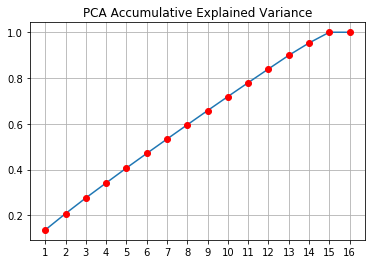

In [84]:
import matplotlib.pyplot as plt

cum_explained_var = []
for i in range(0, len(pca.explained_variance_ratio_)):
    if i == 0:
        cum_explained_var.append(pca.explained_variance_ratio_[i])
    else:
        cum_explained_var.append(pca.explained_variance_ratio_[i] +
                                 cum_explained_var[i - 1])

x_val = range(1, len(cum_explained_var) + 1)
y_val = cum_explained_var

fig = plt.figure()
plt.plot(x_val, y_val)
plt.plot(x_val, y_val, 'or')
plt.title("PCA Accumulative Explained Variance")
plt.xticks(range(1, len(cum_explained_var) + 1))
plt.grid(True)
plt.show()

In [86]:
AttSelection = PCAdata.columns.values.tolist()
AttSelection = AttSelection[:15]
AttSelection = AttSelection + ['Exited']
print(AttSelection)

PCAdata_train_feReduction, PCAtarget_train_feReduction, PCAdata_test_feReduction, PCAtarget_test_feReduction = SplitDataFrameToTrainAndTest(PCAdata[AttSelection], 0.6, 'Exited')
PrintTrainTestInformation(PCAdata_train_feReduction, PCAtarget_train_feReduction, PCAdata_test_feReduction, PCAtarget_test_feReduction)

['principal component1', 'principal component2', 'principal component3', 'principal component4', 'principal component5', 'principal component6', 'principal component7', 'principal component8', 'principal component9', 'principal component10', 'principal component11', 'principal component12', 'principal component13', 'principal component14', 'principal component15', 'Exited']
Train rows and columns :  (6000, 15)
Test rows and columns :  (4000, 15)


In [87]:
# Retest all traditional classification approaches
X_train = PCAdata_train_feReduction
y_train = PCAtarget_train_feReduction
X_test = PCAdata_test_feReduction
y_test = PCAtarget_test_feReduction

NBModel = NaiveBayesLearning(X_train, y_train)
NBAccuracy,NBPredictTest = NaiveBayesTesting(NBModel,X_test, y_test)
print('Naive Bayes accuracy: {:.3f}'.format(NBAccuracy))

LRModel = LogisticRegressionLearning(X_train, y_train)
LRAccuracy,LRPredictTest = LogisticRegressionTesting(LRModel,X_test, y_test)
print('Logistic Regression accuracy: {:.3f}'.format(LRAccuracy))

RFModel = RandomForestLearning(X_train, y_train)
RFAccuracy,RFPredictTest = RandomForestTesting(RFModel,X_test, y_test)
print('Random Forest accuracy: {:.6f}'.format(RFAccuracy))

LiSVMModel = SVMLearning(X_train, y_train)
LiSVMAccuracy,LiSVMPredictTest = SVMTesting(LiSVMModel, X_test, y_test)
print('Linear SVM accuracy: {:.6f}'.format(LiSVMAccuracy))

RBFSVMModel = SVMLearning(X_train, y_train, 'RBF')
RBFSVMAccuracy,RBFSVMPredictTest = SVMTesting(RBFSVMModel, X_test, y_test)
print('RBF SVM accuracy: {:.6f}'.format(RBFSVMAccuracy))

KNNModel = KNNLearning(X_train, y_train)
KNNAccuracy,KNNPredictTest = KNNTesting(KNNModel,X_test, y_test)
print('K Nearest Neighbor accuracy: {:.6f}'.format(KNNAccuracy))

ANNModel = ANNLearning(X_train, y_train)
ANNAccuracy, ANNPredictTest = ANNTesting(ANNModel, X_test, y_test)
print('ANN accuracy: {:.6f}'.format(ANNAccuracy))

Naive Bayes accuracy: 0.809
Logistic Regression accuracy: 0.833
Random Forest accuracy: 0.845250
Linear SVM accuracy: 0.849250
RBF SVM accuracy: 0.798000
K Nearest Neighbor accuracy: 0.815250
ANN accuracy: 0.855250


# **Outlier Removal Approach **

In [88]:
data_encoder.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,HasCrCard,IsActiveMember,EstimatedSalary,Exited,NumOfProducts__1,NumOfProducts__2,NumOfProducts__3,NumOfProducts__4
0,1,15634602,1115,619,0,0,42,2,0.00,1,1,101348.88,1,1,0,0,0
1,2,15647311,1177,608,2,0,41,1,83807.86,0,1,112542.58,0,1,0,0,0
2,3,15619304,2040,502,0,0,42,8,159660.80,1,0,113931.57,1,0,0,1,0
3,4,15701354,289,699,0,0,39,1,0.00,0,0,93826.63,0,0,1,0,0
4,5,15737888,1822,850,2,0,43,2,125510.82,1,1,79084.10,0,1,0,0,0


In [89]:
data_encoder.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 17 columns):
RowNumber           10000 non-null int64
CustomerId          10000 non-null int64
Surname             10000 non-null int64
CreditScore         10000 non-null int64
Geography           10000 non-null int64
Gender              10000 non-null int64
Age                 10000 non-null int64
Tenure              10000 non-null int64
Balance             10000 non-null float64
HasCrCard           10000 non-null int64
IsActiveMember      10000 non-null int64
EstimatedSalary     10000 non-null float64
Exited              10000 non-null int64
NumOfProducts__1    10000 non-null uint8
NumOfProducts__2    10000 non-null uint8
NumOfProducts__3    10000 non-null uint8
NumOfProducts__4    10000 non-null uint8
dtypes: float64(2), int64(11), uint8(4)
memory usage: 1.0 MB


In [90]:
CheckOutlierAtt = ['CreditScore', 'Geography', 'Gender']
LOFOutlierIdx01,LOFFactorData01 = DetectOutlierByLOF(data_encoder, AttList=CheckOutlierAtt, LOFThresh=3.0, neighbors = 10)

print("Size of LOFOutlierIdx : " + str(len(LOFOutlierIdx01)))
print(LOFFactorData01.head())


Size of LOFOutlierIdx : 1167
   index           LOF
0   7134  9.000000e+09
1   9711  8.000000e+09
2   6201  8.000000e+09
3   1005  8.000000e+09
4   2446  8.000000e+09


In [91]:
CheckOutlierAtt = ['Age', 'Tenure', 'Balance']
LOFOutlierIdx02,LOFFactorData02 = DetectOutlierByLOF(data_encoder, AttList=CheckOutlierAtt, LOFThresh=3.0, neighbors = 10)

print("Size of LOFOutlierIdx : " + str(len(LOFOutlierIdx02)))
print(LOFFactorData02.head())

Size of LOFOutlierIdx : 434
   index           LOF
0   1791  1.225392e+13
1   8427  3.768690e+12
2   2810  8.000000e+09
3   9569  8.000000e+09
4   9216  8.000000e+09


In [92]:
CheckOutlierAtt = ['HasCrCard', 'IsActiveMember', 'EstimatedSalary']
LOFOutlierIdx03,LOFFactorData03 = DetectOutlierByLOF(data_encoder, AttList=CheckOutlierAtt, LOFThresh=3.0, neighbors = 10)

print("Size of LOFOutlierIdx : " + str(len(LOFOutlierIdx03)))
print(LOFFactorData03.head())


Size of LOFOutlierIdx : 0
   index       LOF
0   2813  2.275599
1   8397  2.226634
2   3470  2.079527
3   4132  2.013270
4   7478  2.001296


In [93]:
print('LOFOutlierIdx01 :' + str(LOFOutlierIdx01))
print('LOFOutlierIdx02 :' + str(LOFOutlierIdx02))
print('LOFOutlierIdx03 :' + str(LOFOutlierIdx03))

LOFOutlierIdx01 :[7134, 9711, 6201, 1005, 2446, 3454, 8370, 9972, 9741, 6020, 9753, 8455, 1772, 8880, 5196, 1844, 2443, 8107, 9209, 2177, 4266, 2564, 6367, 1489, 2070, 3931, 4377, 5033, 1218, 8942, 955, 3972, 641, 7143, 1130, 952, 8335, 9857, 8007, 5498, 325, 9218, 2074, 7015, 1527, 5460, 2587, 6356, 3267, 9346, 6702, 2172, 4581, 3576, 3040, 2987, 7858, 4892, 8219, 9630, 6619, 6840, 7829, 3435, 3307, 8438, 8343, 6791, 8698, 6079, 1486, 122, 5947, 127, 5130, 9894, 7278, 6774, 9643, 4189, 5167, 6376, 5246, 9758, 6283, 8442, 8465, 1790, 5192, 8414, 8407, 965, 3028, 2021, 5545, 5508, 9707, 1644, 8354, 339, 5873, 3525, 2018, 4536, 2670, 3833, 9331, 2582, 2580, 5611, 5411, 1176, 506, 1318, 6522, 2468, 6547, 7887, 1279, 5656, 7899, 6565, 591, 7753, 4108, 4154, 7258, 5317, 9007, 5119, 6435, 1380, 8217, 5940, 3012, 622, 1331, 5062, 8022, 2649, 5030, 5701, 2013, 9287, 8011, 9410, 6733, 4052, 2884, 2699, 3910, 4014, 2932, 2923, 9767, 2981, 991, 5496, 9136, 5683, 2356, 5685, 982, 3623, 5869, 7466,

In [94]:
OutlierIndex = set(LOFOutlierIdx01 + LOFOutlierIdx02 + LOFOutlierIdx03)
OutlierIndex = list(OutlierIndex)
print(len(OutlierIndex))
print('OutlierIdx : ' + str(OutlierIndex))

1562
OutlierIdx : [8193, 3, 12, 15, 16, 8211, 20, 8216, 8217, 8219, 27, 8224, 50, 54, 8246, 8248, 57, 59, 64, 8257, 8260, 69, 8263, 8270, 84, 8279, 88, 90, 92, 8287, 8295, 8297, 8301, 8303, 114, 8308, 8309, 119, 122, 8314, 127, 132, 8325, 8332, 8334, 8335, 144, 8339, 149, 8343, 154, 157, 8350, 8354, 8360, 171, 8369, 8370, 187, 8385, 8386, 197, 8390, 8389, 8397, 208, 209, 212, 8407, 221, 8414, 223, 8417, 226, 8418, 231, 8424, 8427, 236, 8431, 8438, 8441, 8442, 252, 8446, 255, 256, 258, 262, 8455, 8463, 8465, 281, 8475, 8481, 8482, 289, 292, 300, 302, 303, 308, 8503, 317, 321, 325, 327, 329, 332, 8525, 339, 8531, 8533, 345, 8543, 353, 354, 8548, 8554, 8562, 371, 372, 8565, 374, 8566, 8574, 384, 8589, 398, 399, 404, 405, 8601, 419, 8612, 8611, 427, 8630, 8631, 440, 8635, 446, 448, 8650, 464, 8660, 8663, 8667, 8672, 8681, 491, 8685, 8686, 496, 498, 8691, 504, 506, 8698, 514, 8710, 524, 527, 8719, 8722, 8731, 8734, 8737, 8754, 8757, 8758, 8765, 8767, 575, 8771, 8776, 8779, 587, 8782, 591, 5

In [95]:
data_encoder_mining = data_encoder.copy()
print(data_encoder_mining.shape)
data_encoder_mining = RemoveRowsFromDataFrame(data_encoder_mining,OutlierIndex)
print(data_encoder_mining.shape)

(10000, 17)
(8438, 17)


In [96]:
# Split Train and Test and check shape 
data_train_encoder_mining, target_train_encoder_mining, data_test_encoder_mining, target_test_encoder_mining = SplitDataFrameToTrainAndTest(data_encoder_mining, 0.6, 'Exited')
PrintTrainTestInformation(data_train_encoder_mining, target_train_encoder_mining, data_test_encoder_mining, target_test_encoder_mining)

Train rows and columns :  (5063, 16)
Test rows and columns :  (3375, 16)


In [97]:
# Retest all traditional classification approaches
X_train = data_train_encoder_mining
y_train = target_train_encoder_mining
X_test = data_test_encoder_mining
y_test = target_test_encoder_mining

NBModel = NaiveBayesLearning(X_train, y_train)
NBAccuracy,NBPredictTest = NaiveBayesTesting(NBModel,X_test, y_test)
print('Naive Bayes accuracy: {:.3f}'.format(NBAccuracy))

LRModel = LogisticRegressionLearning(X_train, y_train)
LRAccuracy,LRPredictTest = LogisticRegressionTesting(LRModel,X_test, y_test)
print('Logistic Regression accuracy: {:.3f}'.format(LRAccuracy))

RFModel = RandomForestLearning(X_train, y_train)
RFAccuracy,RFPredictTest = RandomForestTesting(RFModel,X_test, y_test)
print('Random Forest accuracy: {:.6f}'.format(RFAccuracy))

LiSVMModel = SVMLearning(X_train, y_train)
LiSVMAccuracy,LiSVMPredictTest = SVMTesting(LiSVMModel, X_test, y_test)
print('Linear SVM accuracy: {:.6f}'.format(LiSVMAccuracy))

RBFSVMModel = SVMLearning(X_train, y_train, 'RBF')
RBFSVMAccuracy,RBFSVMPredictTest = SVMTesting(RBFSVMModel, X_test, y_test)
print('RBF SVM accuracy: {:.6f}'.format(RBFSVMAccuracy))

KNNModel = KNNLearning(X_train, y_train)
KNNAccuracy,KNNPredictTest = KNNTesting(KNNModel,X_test, y_test)
print('K Nearest Neighbor accuracy: {:.6f}'.format(KNNAccuracy))

ANNModel = ANNLearning(X_train, y_train)
ANNAccuracy, ANNPredictTest = ANNTesting(ANNModel, X_test, y_test)
print('ANN accuracy: {:.6f}'.format(ANNAccuracy))

Naive Bayes accuracy: 0.778
Logistic Regression accuracy: 0.787
Random Forest accuracy: 0.850667
Linear SVM accuracy: 0.786667
RBF SVM accuracy: 0.786667
K Nearest Neighbor accuracy: 0.725926
ANN accuracy: 0.464296


# **Neural Network Approach**

In [102]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint

seed = 42
np.random.seed(seed)

## Create our model
model = Sequential()

# 1st layer: input_dim=8, 12 nodes, RELU
model.add(Dense(12, input_dim=16, init='uniform', activation='relu'))
# 2nd layer: 8 nodes, RELU
model.add(Dense(8, init='uniform', activation='relu'))
# 3nd layer: 4 nodes, RELU
model.add(Dense(4, init='uniform', activation='relu'))
# output layer: dim=1, activation sigmoid
model.add(Dense(1, init='uniform', activation='sigmoid' ))

# Compile the model
model.compile(loss='binary_crossentropy',   # since we are predicting 0/1
             optimizer='adam',
             metrics=['accuracy'])


In [103]:
# Retest all traditional classification approaches
X_train = data_train_encoder_mining
y_train = target_train_encoder_mining
X_test = data_test_encoder_mining
y_test = target_test_encoder_mining

NB_EPOCHS = 100  # num of epochs to test for
BATCH_SIZE = 15

# checkpoint: store the best model
ckpt_model = 'pima-weights.best.hdf5'
checkpoint = ModelCheckpoint(ckpt_model, 
                            monitor='val_acc',
                            verbose=1,
                            save_best_only=True,
                            mode='max')
callbacks_list = [checkpoint]

print('Starting training...')
# train the model, store the results for plotting
history = model.fit(X_train,
                    y_train,
                    validation_data=(X_test, y_test),
                    nb_epoch=NB_EPOCHS,
                    batch_size=BATCH_SIZE,
                    callbacks=callbacks_list,
                    verbose=0)


Starting training...

Epoch 00001: val_acc improved from -inf to 0.78667, saving model to pima-weights.best.hdf5

Epoch 00002: val_acc did not improve from 0.78667

Epoch 00003: val_acc did not improve from 0.78667

Epoch 00004: val_acc did not improve from 0.78667

Epoch 00005: val_acc did not improve from 0.78667

Epoch 00006: val_acc did not improve from 0.78667

Epoch 00007: val_acc did not improve from 0.78667

Epoch 00008: val_acc did not improve from 0.78667

Epoch 00009: val_acc did not improve from 0.78667

Epoch 00010: val_acc did not improve from 0.78667

Epoch 00011: val_acc did not improve from 0.78667

Epoch 00012: val_acc did not improve from 0.78667

Epoch 00013: val_acc did not improve from 0.78667

Epoch 00014: val_acc did not improve from 0.78667

Epoch 00015: val_acc did not improve from 0.78667

Epoch 00016: val_acc did not improve from 0.78667

Epoch 00017: val_acc did not improve from 0.78667

Epoch 00018: val_acc did not improve from 0.78667

Epoch 00019: val_ac

# **Bagging Boosting and Stacking **

In [104]:
X = data_encoder_mining.copy()
X = X.drop('Exited', 1)
y = data_encoder_mining[['Exited']]
X.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,HasCrCard,IsActiveMember,EstimatedSalary,NumOfProducts__1,NumOfProducts__2,NumOfProducts__3,NumOfProducts__4
0,1,15634602,1115,619,0,0,42,2,0.00,1,1,101348.88,1,0,0,0
1,2,15647311,1177,608,2,0,41,1,83807.86,0,1,112542.58,1,0,0,0
2,3,15619304,2040,502,0,0,42,8,159660.80,1,0,113931.57,0,0,1,0
3,5,15737888,1822,850,2,0,43,2,125510.82,1,1,79084.10,1,0,0,0
4,6,15574012,537,645,2,1,44,8,113755.78,1,0,149756.71,0,1,0,0


In [106]:
from sklearn import model_selection
NBModel = NaiveBayesLearning(X_train, y_train)
LRModel = LogisticRegressionLearning(X_train, y_train)
RFModel = RandomForestLearning(X_train, y_train)
LiSVMModel = SVMLearning(X_train, y_train)
RBFSVMModel = SVMLearning(X_train, y_train, 'RBF')
KNNModel = KNNLearning(X_train, y_train)
ANNModel = ANNLearning(X_train, y_train)


print('5-fold cross validation:\n')
labels = ['NaiveBayesLearning', 'LogisticRegressionLearning', 'RandomForestLearning', 
          'SVMLearningLinear', 'SVMLearningRBF', 'KNNLearning', 'ANNLearning']
for clf, label in zip([NBModel, LRModel, RFModel, LiSVMModel, RBFSVMModel, KNNModel, ANNModel], labels):
    scores = model_selection.cross_val_score(clf, X, y, cv=5, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))


5-fold cross validation:

Accuracy: 0.78 (+/- 0.00) [NaiveBayesLearning]
Accuracy: 0.79 (+/- 0.00) [LogisticRegressionLearning]
Accuracy: 0.84 (+/- 0.02) [RandomForestLearning]
Accuracy: 0.79 (+/- 0.00) [SVMLearningLinear]
Accuracy: 0.79 (+/- 0.00) [SVMLearningRBF]
Accuracy: 0.73 (+/- 0.01) [KNNLearning]
Accuracy: 0.79 (+/- 0.00) [ANNLearning]


In [107]:
from mlxtend.classifier import EnsembleVoteClassifier
eclf = EnsembleVoteClassifier(clfs=[RFModel, NBModel, KNNModel], weights=[1,1,1])

labels = ['RandomForestLearning', 'NaiveBayesLearning', 'KNNLearning', 'Ensemble']
for clf, label in zip([RFModel, NBModel, KNNModel, eclf], labels):
    scores = model_selection.cross_val_score(clf, X, y, cv=5,scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.85 (+/- 0.01) [RandomForestLearning]
Accuracy: 0.78 (+/- 0.00) [NaiveBayesLearning]
Accuracy: 0.73 (+/- 0.01) [KNNLearning]
Accuracy: 0.81 (+/- 0.01) [Ensemble]


In [108]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import six
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator
class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):
    """ A majority vote ensemble classifier
    Parameters
    classifiers : array-like, shape = [n_classifiers]  Different classifiers for the ensemble
    vote : str, {'classlabel', 'probability'} (default='label')
      If 'classlabel' the prediction is based on the argmax of class labels. Else if 'probability', the argmax of the sum of probabilities is used to predict the class label (recommended for calibrated classifiers).
    weights : array-like, shape = [n_classifiers], optional (default=None)
      If a list of `int` or `float` values are provided, the classifiers are weighted by importance; Uses uniform weights if `weights=None`.
    """
    def __init__(self, classifiers, vote='classlabel', weights=None):
        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights
    def fit(self, X, y):
        """ Fit classifiers. Parameters
        X : {array-like, sparse matrix}, shape = [n_samples, n_features] Matrix of training samples.
        y : array-like, shape = [n_samples] Vector of target class labels.
        Returns self : object
        """
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError("vote must be 'probability' or 'classlabel'" "; got (vote=%r)" % self.vote)
        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError('Number of classifiers and weights must be equal''; got %d weights, %d classifiers' %   
            (len(self.weights), len(self.classifiers)))
        # Use LabelEncoder to ensure class labels start with 0, which is important for np.argmax call in self.predict
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self
    def predict(self, X):
        """ Predict class labels for X.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features] Matrix of training samples.
        Returns ----------
        maj_vote : array-like, shape = [n_samples] Predicted class labels.
        """
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:  # 'classlabel' vote
            #  Collect results from clf.predict calls
            predictions = np.asarray([clf.predict(X) for clf in self.classifiers_]).T
            maj_vote = np.apply_along_axis( lambda x: np.argmax(np.bincount(x, weights=self.weights)),
                                      axis=1,
                                      arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote
    def predict_proba(self, X):
        """ Predict class probabilities for X.
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and n_features is the number of features.
        Returns
        avg_proba : array-like, shape = [n_samples, n_classes] Weighted average probability for each class per sample.
        """
        probas = np.asarray([clf.predict_proba(X)  for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba
    def get_params(self, deep=True):
        """ Get classifier parameter names for GridSearch"""
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in six.iteritems(self.named_classifiers):
                for key, value in six.iteritems(step.get_params(deep=True)):
                    out['%s__%s' % (name, key)] = value
            return out


In [109]:
# Majority Rule (hard) Voting

mv_clf = MajorityVoteClassifier(classifiers=[RFModel, NBModel, KNNModel])

labels = ['RandomForestLearning', 'NaiveBayesLearning', 'KNNLearning', 'Majority voting']
all_clf = [RFModel, NBModel, KNNModel, mv_clf]

for clf, label in zip(all_clf, labels):
    scores = cross_val_score(estimator=clf,
                             X=X,
                             y=y,
                             cv=5,
                             scoring='accuracy')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))

ROC AUC: 0.85 (+/- 0.01) [RandomForestLearning]
ROC AUC: 0.78 (+/- 0.00) [NaiveBayesLearning]
ROC AUC: 0.73 (+/- 0.01) [KNNLearning]
ROC AUC: 0.81 (+/- 0.01) [Majority voting]


In [111]:
# Split Train and Test and check shape 
data_train_encoder_mining, target_train_encoder_mining, data_test_encoder_mining, target_test_encoder_mining = SplitDataFrameToTrainAndTest(data_encoder_mining, 0.6, 'Exited')
PrintTrainTestInformation(data_train_encoder_mining, target_train_encoder_mining, data_test_encoder_mining, target_test_encoder_mining)

# Retest all traditional classification approaches
X_train = data_train_encoder_mining
y_train = target_train_encoder_mining
X_test = data_test_encoder_mining
y_test = target_test_encoder_mining

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='entropy', max_depth=None, random_state=1)
bag = BaggingClassifier(base_estimator=tree,
                        n_estimators=500, 
                        max_samples=1.0, 
                        max_features=1.0, 
                        bootstrap=True, 
                        bootstrap_features=False, 
                        n_jobs=1, 
                        random_state=1)

from sklearn.metrics import accuracy_score

tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Decision tree train/test accuracies %.3f/%.3f'
      % (tree_train, tree_test))

bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)

bag_train = accuracy_score(y_train, y_train_pred) 
bag_test = accuracy_score(y_test, y_test_pred) 
print('Bagging train/test accuracies %.3f/%.3f'
      % (bag_train, bag_test))

Train rows and columns :  (5063, 16)
Test rows and columns :  (3375, 16)
Decision tree train/test accuracies 1.000/0.798
Bagging train/test accuracies 1.000/0.855


In [112]:
from sklearn.ensemble import AdaBoostClassifier

tree = DecisionTreeClassifier(criterion='entropy', max_depth=None, random_state=1)
ada = AdaBoostClassifier(base_estimator=tree, n_estimators=500, learning_rate=0.1, random_state=1)
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Decision tree train/test accuracies %.3f/%.3f'% (tree_train, tree_test))

ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)

ada_train = accuracy_score(y_train, y_train_pred) 
ada_test = accuracy_score(y_test, y_test_pred) 
print('AdaBoost train/test accuracies %.3f/%.3f'
      % (ada_train, ada_test))

Decision tree train/test accuracies 1.000/0.798
AdaBoost train/test accuracies 1.000/0.793


In [113]:
from mlxtend.classifier import StackingClassifier
import matplotlib.gridspec as gridspec
import itertools
from mlxtend.plotting import plot_learning_curves
from mlxtend.plotting import plot_decision_regions

lr = LogisticRegression()
sclf = StackingClassifier(classifiers=[RFModel, NBModel, KNNModel], meta_classifier=lr)

label = ['Random Forest', 'Naive Bayes', 'KNN', 'Stacking Classifier']
clf_list = [RFModel, NBModel, KNNModel, sclf]


clf_cv_mean = []
clf_cv_std = []
for clf, label in zip(clf_list, label):
    scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
    print("Accuracy: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label))
    clf_cv_mean.append(scores.mean())
    clf_cv_std.append(scores.std())        
    clf.fit(X, y)

Accuracy: 0.85 (+/- 0.01) [Random Forest]
Accuracy: 0.78 (+/- 0.00) [Naive Bayes]
Accuracy: 0.73 (+/- 0.01) [KNN]
Accuracy: 0.84 (+/- 0.02) [Stacking Classifier]
